In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
PATH = "data/CodeWorkout/S19"
data = ProgSnap2Dataset(PATH)

In [3]:
main_table = data.get_main_table()
student_table = data.load_link_table('Subject')

In [4]:
# Get the SubjectIDs where the final grade is non-0
# A 0 grade indicates the student did not take the final
print(len(student_table.index))
subject_ids = set(student_table[student_table['X-Grade'] != 0][PS2.SubjectID].unique())
subject_ids = subject_ids.intersection(set(student_table['SubjectID'].unique()))
len(subject_ids)

381


348

We want to confirm that our selected students have a good and well-distributed number of attempts at all the problems in the dataset.

In [5]:
# First we check how many problems each student attempted
main_table_filtered = main_table[main_table[PS2.SubjectID].isin(subject_ids)]
problems_per_student = main_table_filtered.groupby(by=['SubjectID']).apply(lambda rows: len(rows[PS2.ProblemID].unique()))
# 75% of problems were attempted by at least 40 studens, so that's good
problems_per_student.describe()

count    346.000000
mean      42.855491
std       10.331712
min        1.000000
25%       40.000000
50%       48.500000
75%       50.000000
max       50.000000
dtype: float64

In [6]:
# Only 3 attempted fewer than 10 problems
sum(problems_per_student < 10)

3

In [7]:
# Next we see how many students attempted each problem
students_per_problem = main_table_filtered.groupby(by=['AssignmentID', 'ProblemID']).apply(lambda rows: len(rows[PS2.SubjectID].unique()))
students_per_problem.describe()

count     50.000000
mean     296.560000
std       14.642906
min      267.000000
25%      285.000000
50%      295.500000
75%      309.750000
max      324.000000
dtype: float64

<BarContainer object of 50 artists>

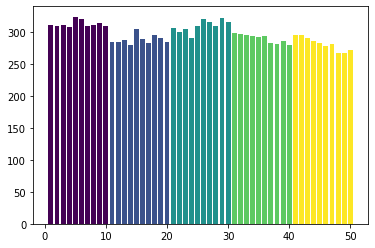

In [8]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

assignment_ids = list(students_per_problem.keys().map(lambda x: x[0]))
assignment_ids = [sorted(assignment_ids).index(x) for x in assignment_ids]
colors = [viridis((float(i)-min(assignment_ids))/(max(assignment_ids)-min(assignment_ids))) for i in assignment_ids]

# There's a slight drop-off by assignment, but overall they're well-attempted
plt.bar(range(1,51), students_per_problem, color=colors)

In [9]:
main_table_filtered[PS2.Score][0]

1.0

In [10]:
runs = main_table_filtered[main_table_filtered[PS2.EventType] == 'Run.Program']

def get_attempts(rows):
    scores = rows[PS2.Score]
    # If they scored 1, we return the first time they did so
    if (scores.max() == 1):
        # Argmax returns the first index of the highest score
        # Since the array is 0-indexed, we return +1
        return rows[PS2.Score].argmax() + 1
    return len(rows.index)
    

scores = runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(get_attempts)
scores.describe()

count    14828.000000
mean         4.196318
std          5.879822
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [11]:
# Confirm that this is different than just the count of runs
runs.groupby([PS2.SubjectID, PS2.AssignmentID, PS2.ProblemID]).apply(lambda x: len(x.index)).describe()

count    14828.000000
mean         4.345090
std          6.076818
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         93.000000
dtype: float64

In [12]:
student_scores = scores.to_frame('Attempts').reset_index()
student_scores.head()

,SubjectID,AssignmentID,ProblemID,Attempts
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17


In [13]:
problem_attempt_75th = student_scores.groupby(PS2.ProblemID).apply(lambda x: x.Attempts.quantile(0.75))
problem_attempt_75th.head()

ProblemID
1      2.0
3      4.0
5      4.0
12     2.0
13    11.0
dtype: float64

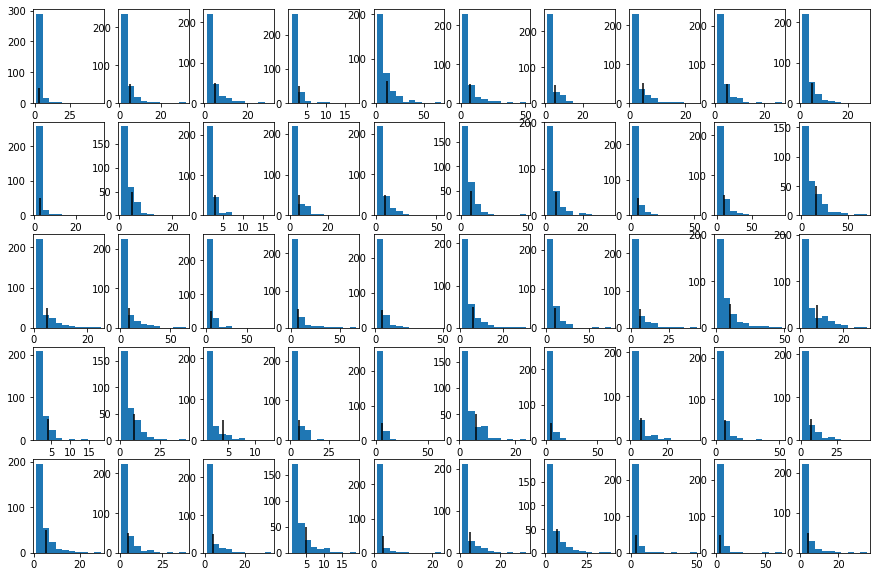

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 10]

problem_ids = list(student_scores.ProblemID.unique())
fig, axs = plt.subplots(5, 10)
for i in range(5):
    for j in range(10):
        problem_id = problem_ids[i * 10 + j]
        attempts = student_scores[student_scores[PS2.ProblemID] == problem_id].Attempts
        p75 = problem_attempt_75th[problem_id] + 1
        axs[i, j].hist(attempts)
        axs[i, j].vlines(p75, 0, 50)

In [20]:
cutoffs = student_scores['ProblemID'].apply(lambda x: problem_attempt_75th[x])
student_scores['Label'] = student_scores['Attempts'] <= cutoffs
student_scores['Label'].value_counts()

True     11531
False     3297
Name: Label, dtype: int64

(array([  1.,   1.,   0.,   4.,  18.,  34.,  54.,  51.,  76., 107.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

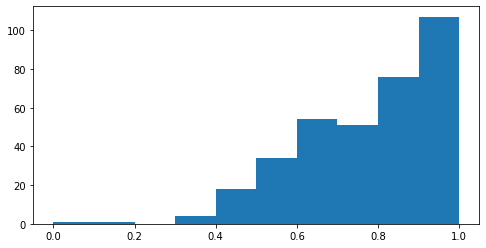

In [53]:
matplotlib.rcParams['figure.figsize'] = [8, 4]

# The percentage of struggling problems per student is well-distributed
plt.hist(student_scores.groupby(PS2.SubjectID)['Label'].mean())

In [42]:
problem_ids = student_scores[PS2.ProblemID].unique()
assignment_ids = student_scores[PS2.AssignmentID].unique()

test_problem_ids = np.array([student_scores[student_scores[PS2.AssignmentID] == assignmentID][PS2.ProblemID].unique()[-3:] for assignmentID in assignment_ids]).flatten()
test_problem_ids = list(test_problem_ids)
test_problem_ids

[234, 235, 236, 100, 101, 102, 39, 40, 128, 106, 107, 108, 71, 112, 118]

In [43]:
student_scores['IsTestProblem'] = student_scores[PS2.ProblemID].apply(lambda problem_id: problem_id in test_problem_ids)
student_scores.head(15)

,SubjectID,AssignmentID,ProblemID,Attempts,Label,IsTestProblem
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,False,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,False,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,False,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,False
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,False,False
5,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,232,9,False,False
6,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,233,1,True,False
7,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,234,3,True,True
8,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,235,1,True,True
9,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,236,3,True,True


<BarContainer object of 50 artists>

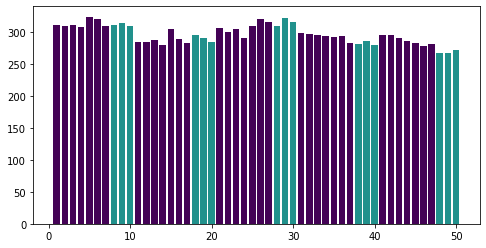

In [54]:
# Next we plot the number of attemptes on each problem (x) / assignment (color)
from matplotlib.cm import viridis

problem_ids = list(students_per_problem.keys().map(lambda x: x[1]))
colors = [viridis(0.5 if i in test_problem_ids else 1) for i in problem_ids]

# There's a slight drop-off by assignment, but overall they're well-attempted
plt.bar(range(1,51), students_per_problem, color=colors)

In [26]:
train_ids, test_ids = train_test_split(list(subject_ids), test_size=0.25, random_state=1234)

In [28]:
student_scores_train = student_scores[student_scores[PS2.SubjectID].isin(train_ids)]
student_scores_test = student_scores[student_scores[PS2.SubjectID].isin(test_ids)]